<a href="https://colab.research.google.com/github/Dimonfordont/DS_course/blob/main/Neural_networks/CNN/Basic/torch_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import display, clear_output

In [ ]:
!pip install -q --upgrade wandb
clear_output()

In [ ]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import wandb

from matplotlib import pyplot as plt
from torch.nn import functional as Functional
from torchvision import datasets
from tqdm import *

In [ ]:
%matplotlib inline

In [ ]:
WNB_FLAG = True
API_KEY = ''
WNB_PROJECT = 'torch_mnist'
WNB_LOGIN = 'dimildizio'

In [ ]:
TRAIN_BATCH = 64
TEST_BATCH = 512
N_IN = 256
N_OUT = 10
LR = 0.15
NUM_WORKERS = 2
N_EPOCHS = 5
SEED = 42
MNIST_MEAN = 0.1307
MNIST_STD = 0.3081
PARAM_DICT = {'epochs':N_EPOCHS, 'train_batch':TRAIN_BATCH, 'num_workers':NUM_WORKERS,
              'lr':LR, 'seed':SEED, 'classes':N_OUT}

In [ ]:
def seed_all(seed):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

seed_all(SEED)

In [ ]:
transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(MNIST_MEAN, MNIST_STD)
                      ])

In [ ]:
train_data = datasets.MNIST(root='./data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = TRAIN_BATCH,
                                         num_workers = NUM_WORKERS, pin_memory = True,
                                         shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = TEST_BATCH,
                                         num_workers = NUM_WORKERS, pin_memory = True,
                                         shuffle = False)

In [ ]:
print('Train:', train_loader.dataset.data.shape)
print('Test:', test_loader.dataset.data.shape)

Train: torch.Size([60000, 28, 28])
Test: torch.Size([10000, 28, 28])


In [ ]:
img=train_loader.dataset.data[1].numpy()

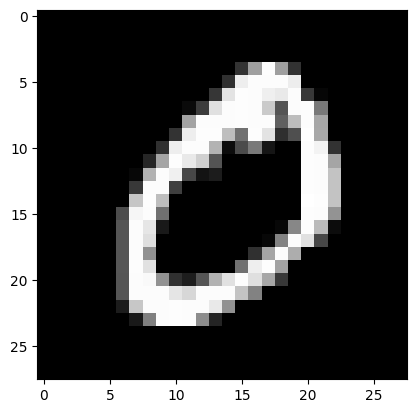

In [ ]:
plt.imshow(img, cmap = 'gray')
plt.show()

In [ ]:
for data in train_loader:
    print(len(data))
    print('Images:',data[0].shape)
    print('Labels:', data[1].shape)
    break
print(len(train_loader))

2
Images: torch.Size([64, 1, 28, 28])
Labels: torch.Size([64])
938


In [ ]:
class MyConv(nn.Module):
  def __init__(self, nin = N_IN, nout = N_OUT):
    super(MyConv, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=32, kernel_size=3)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(nin, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, nout)

  def convolution(self, conv, x):
    convd = conv(x)
    activated = Functional.relu(convd)
    pooled = self.pool(activated)
    return pooled

  def fcs(self, x):
    layerd = self.fc1(x)
    activated = Functional.relu(layerd)
    layerd = self.fc2(activated)
    activated = Functional.relu(layerd)
    result = self.fc3(activated)
    return result

  def forward(self, x):
    x = self.convolution(self.conv1, x)
    x = self.convolution(self.conv2, x)
    #print('Convs output size:',x.shape)
    #view(-1, 64, 16*4*4)
    x = self.flatten(x)
    #use all mlps
    x = self.fcs(x)
    return x

In [ ]:
net = MyConv()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=LR)

In [ ]:
for epoch in tqdm_notebook(range(N_EPOCHS)):
  print('EPOCH:', epoch+1)
  for num, batch in enumerate(tqdm_notebook(train_loader)):
    loss_per_batch = 0.0
    optimizer.zero_grad()
    batch_X, batch_y = batch

    pred_y = net(batch_X)
    batch_loss = loss(pred_y, batch_y)
    batch_loss.backward()
    optimizer.step()

    loss_per_batch += batch_loss.item()
    if not num % 400:
      print(f'batch: {num}\nloss: {loss_per_batch}')
      loss_per_batch = 0.0
print('Finished training')

<ipython-input-61-c2b45e4b4c59>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(N_EPOCHS)):


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0


<ipython-input-61-c2b45e4b4c59>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/938 [00:00<?, ?it/s]

batch: 0
loss: 2.299473524093628
batch: 100
loss: 2.0243117809295654
batch: 200
loss: 1.1062376499176025
batch: 300
loss: 0.5462634563446045
batch: 400
loss: 0.5711402297019958
batch: 500
loss: 0.4796224534511566
batch: 600
loss: 0.5083009600639343
batch: 700
loss: 0.2678655982017517
batch: 800
loss: 0.45245474576950073
batch: 900
loss: 0.3551263213157654
EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]

batch: 0
loss: 0.14713707566261292
batch: 100
loss: 0.23632977902889252
batch: 200
loss: 0.27287960052490234
batch: 300
loss: 0.11737588047981262
batch: 400
loss: 0.28134453296661377
batch: 500
loss: 0.3892837464809418
batch: 600
loss: 0.1852506548166275
batch: 700
loss: 0.18132103979587555
batch: 800
loss: 0.12468929588794708
batch: 900
loss: 0.3047921061515808
EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]

batch: 0
loss: 0.17549556493759155
batch: 100
loss: 0.14752228558063507
batch: 200
loss: 0.30255618691444397
batch: 300
loss: 0.0998007208108902
batch: 400
loss: 0.20626263320446014
batch: 500
loss: 0.2017473429441452
batch: 600
loss: 0.05691405385732651
batch: 700
loss: 0.054551493376493454
batch: 800
loss: 0.14481012523174286
batch: 900
loss: 0.11469674855470657
EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]

batch: 0
loss: 0.18384556472301483
batch: 100
loss: 0.30032283067703247
batch: 200
loss: 0.09678401052951813
batch: 300
loss: 0.08188000321388245
batch: 400
loss: 0.12028265744447708
batch: 500
loss: 0.06058155372738838
batch: 600
loss: 0.10001840442419052
batch: 700
loss: 0.04998436197638512
batch: 800
loss: 0.12975351512432098
batch: 900
loss: 0.16917772591114044
EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]

batch: 0
loss: 0.13245724141597748
batch: 100
loss: 0.05553488805890083
batch: 200
loss: 0.08632879704236984
batch: 300
loss: 0.09140466898679733
batch: 400
loss: 0.04250320419669151
batch: 500
loss: 0.04184185713529587
batch: 600
loss: 0.0472867377102375
batch: 700
loss: 0.06577321141958237
batch: 800
loss: 0.0214013010263443
batch: 900
loss: 0.359427809715271
Finished training


In [ ]:
classes = tuple(str(i) for i in range(10))
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

In [ ]:
with torch.no_grad():
  for data in test_loader:
    images, labels = data
    pred_y = net(images)
    maxval, pred_labels = torch.max(pred_y, 1)
    mask = (pred_labels == labels).squeeze()
    for i in range(10):
      label = labels[i]
      class_correct[label] += mask[i].item()
      class_total[label] +=1

for i in range(10):
    print(f'Accuracy of {classes[i]}: {round(100 * (class_correct[i]/class_total[i]),2)}%')

Accuracy of 0: 100.0%
Accuracy of 1: 95.24%
Accuracy of 2: 100.0%
Accuracy of 3: 95.24%
Accuracy of 4: 100.0%
Accuracy of 5: 92.86%
Accuracy of 6: 100.0%
Accuracy of 7: 100.0%
Accuracy of 8: 100.0%
Accuracy of 9: 100.0%


New let's gether it all together

In [ ]:
class ModelRunner:
  def __init__(self, lr = LR, epochs = N_EPOCHS, train_loader=train_loader, test_loader=test_loader, m_in=N_IN, m_out=N_OUT):
    self.traindata = train_loader
    self.testdata = test_loader

    self.lr = LR
    self.epochs = epochs

    self.model = MyConv(nin = m_in, nout = m_out)
    self.loss = nn.CrossEntropyLoss()

    self.optimizer = torch.optim.SGD(self.model.parameters(),lr=lr)#, lr=lr)
    self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma = 0.9)

  def get_correct_score(self, pred_ys, target):
    pred_p = pred_ys.argmax(dim=1, keepdim=True)
    correct_mask = pred_p.eq(target.view_as(pred_p))
    return correct_mask.sum().item()

  def print_n_log(self, correct, iloss, mode = 'train'):
    myset = self.traindata if mode == 'train' else self.testdata
    predicted = correct / len(myset.dataset)
    tqdm.write(f'\nMode: {mode}\nAvgLoss: {iloss}\nAccuracy:{round(predicted, 2)}%\n')
    if WNB_FLAG:
      wandb.log({mode+'_loss':iloss, mode+'_accuracy':predicted})

  def predict(self, data, target):
    preds = self.model(data)
    myloss = self.loss(preds, target)
    score = self.get_correct_score(preds, target)
    return preds, myloss, score

  def train(self):
    print('training')
    correct = 0
    self.model.train()
    for _batch_idx, (data, target) in tqdm(enumerate(self.traindata), total=len(self.traindata)):
      self.optimizer.zero_grad()

      preds, train_loss, score = self.predict(data, target)
      correct+=score

      train_loss.backward()
      self.optimizer.step()

    self.print_n_log(correct, train_loss)
    self.scheduler.step()

  def test(self):
    correct = 0
    self.model.eval()
    with torch.no_grad():
      for data, target in self.testdata:
        preds, test_loss, score = self.predict(data, target)
        correct += score
    self.print_n_log(correct, test_loss, 'test')

  def run_loop(self):
    print('Total Epochs:', self.epochs)
    for epoch in range(self.epochs):
      print('Epoch:', epoch+1)
      self.train()
      self.test()

In [ ]:
def log_wnb(model):
  if WNB_FLAG:
    os.environ["WANDB_API_KEY"] = API_KEY
    wandb.init(project=WNB_PROJECT, entity=WNB_LOGIN, reinit=True, config=PARAM_DICT)
    wandb.watch(model, log='all')

In [ ]:
def mainloop(train, test, m_in=N_IN, m_out = N_OUT, lr = LR, epochs=N_EPOCHS):
  seed_all(SEED)
  runner = ModelRunner(m_in=m_in, m_out=m_out, lr=lr, epochs=epochs, train_loader=train, test_loader=test)
  log_wnb(runner.model)
  runner.run_loop()

In [ ]:
WNB_FLAG=True

In [ ]:
mainloop(train_loader, test_loader)

test_accuracy,▁▅▆▇█
test_loss,█▄▃▂▁
train_accuracy,▁▇▇██
train_loss,█▂▃▄▁
test_accuracy,0.7359
test_loss,0.67972
train_accuracy,0.74043
train_loss,0.55081


Total Epochs: 5
Epoch: 1
training


100%|██████████| 938/938 [00:27<00:00, 33.71it/s]


Mode: train
AvgLoss: 0.06213150545954704
Accuracy:0.92%




Mode: test
AvgLoss: 0.20066364109516144
Accuracy:0.97%

Epoch: 2
training


100%|██████████| 938/938 [00:27<00:00, 33.72it/s]


Mode: train
AvgLoss: 0.3743281364440918
Accuracy:0.98%




Mode: test
AvgLoss: 0.1666664332151413
Accuracy:0.97%

Epoch: 3
training


100%|██████████| 938/938 [00:27<00:00, 33.50it/s]


Mode: train
AvgLoss: 0.27227768301963806
Accuracy:0.98%




Mode: test
AvgLoss: 0.12645183503627777
Accuracy:0.98%

Epoch: 4
training


100%|██████████| 938/938 [00:27<00:00, 33.57it/s]


Mode: train
AvgLoss: 0.0027527865022420883
Accuracy:0.98%




Mode: test
AvgLoss: 0.11737363040447235
Accuracy:0.98%

Epoch: 5
training


100%|██████████| 938/938 [00:27<00:00, 33.89it/s]


Mode: train
AvgLoss: 0.04171111807227135
Accuracy:0.99%




Mode: test
AvgLoss: 0.1319022923707962
Accuracy:0.98%



Interestingly SDG has shown better results than even AdamW

In [ ]:

F_N_IN = 32*5*5
F_N_OUT = 10
LRF = 0.5
F_N_EPOCHS = 10
MNISTF_MEAN = 0.2859
MNISTF_STD = 0.3530
PARAM_DICT = {'epochs':F_N_EPOCHS, 'train_batch':TRAIN_BATCH, 'num_workers':NUM_WORKERS,
              'lr':LRF, 'seed':SEED, 'classes':F_N_OUT}

In [ ]:
transform_f = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(MNISTF_MEAN, MNISTF_STD)
                      ])

In [ ]:
train_data_f = datasets.FashionMNIST(root='./data', train=True,
                                   download=True, transform=transform_f)
test_data_f = datasets.FashionMNIST(root='./data', train=False,
                                  download=True, transform=transform_f)

train_loader_f = torch.utils.data.DataLoader(train_data_f, batch_size = TRAIN_BATCH,
                                         num_workers = NUM_WORKERS, pin_memory = True,
                                         shuffle = True)
test_loader_f = torch.utils.data.DataLoader(test_data_f, batch_size = TEST_BATCH,
                                         num_workers = NUM_WORKERS, pin_memory = True,
                                         shuffle = False)

In [ ]:
API_KEY = ''
WNB_PROJECT = 'mlp_vs_cnn_fmnist'
WNB_LOGIN = 'dimildizio'

In [ ]:
WNB_FLAG=True

In [ ]:
mainloop(train_loader_f, test_loader_f, m_in=F_N_IN, m_out = F_N_OUT, lr = LRF, epochs=F_N_EPOCHS)